In [1]:
import numpy as np
import tensorflow as tf
from utility_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
X_old,Y_old = generate_data(
    xlim = [-1,1],
    ylim = [-1,1], 
    n_point_per_axis = [20,10], 
    lenth_per_slab = 0.4, 
    width_per_slab = 0.2, 
    gap_to_edge_1 = [0.1,0.15],
    gap_to_edge_2 = [0.1, 0.5],
    n_slab1 = 3, 
    n_slab2 = 2,
)
Y_old = tf.cast(Y_old,'int32')
newcolors = np.array([[0/256, 0/256, 0/256, 1],
                   [256/256, 256/256, 256/256, 1]])
newcmp = ListedColormap(newcolors)

blockcolors = np.array([[256/256, 0/256, 0/256, 1],
                   [0/256, 0/256, 256/256, 1]])
blockcmp = ListedColormap(blockcolors)



In [3]:
def create_VP2():
    xx = np.linspace(-1,1,30)
    yy = np.linspace(-1,1,30)
    X1,X2 = np.meshgrid(xx,yy)
    X1 = np.reshape(X1,[-1,1])
    X2 = np.reshape(X2,[-1,1])
    new_X = np.concatenate([X1,X2],axis = -1)

    new_Y = np.zeros([np.shape(new_X)[0]])+2
    return new_X, new_Y

In [4]:
new_X, new_Y = create_VP2()

X = tf.concat([X_old,new_X], axis = 0)
Y = tf.concat([Y_old,new_Y], axis = 0)

In [11]:
class BMF_loss(tf.keras.losses.Loss):
    def __init__(self, coeff, beta_func = 0):
        super().__init__()
        self.coeff = coeff
        self.beta_func = beta_func
    def call(self, y_true, y_pred):
        inp = y_true[:,1:]
        y_true = y_true[:,0]
        base = [1.0, 1.0, 0.0]
        indicator = tf.gather(base, indices = tf.cast(y_true,'int32'))
        alphas = tf.math.exp(y_pred)+1e-8
        batch_size = tf.shape(inp)[0]
        zer = tf.fill([batch_size,1],0.0000003)

        betas = tf.ones_like(y_pred) * self.beta_func(tf.stop_gradient(inp))

        a_ans = tf.gather(tf.concat([alphas,zer],axis = -1),axis=-1, indices = tf.cast(y_true,'int32'), batch_dims = 1)

        a_zero = tf.math.reduce_sum(alphas,-1)
        
        l1_loss = indicator*(tf.math.digamma(a_ans) - tf.math.digamma(a_zero))


        loss1 = tf.math.lgamma(a_zero) - tf.math.reduce_sum(tf.math.lgamma(alphas), -1)
        loss2 = tf.math.reduce_sum((alphas - betas)*(tf.math.digamma(alphas) - tf.math.digamma(tf.expand_dims(a_zero,-1))),-1)

        kl_loss = loss1 + loss2

        loss = tf.math.reduce_mean(self.coeff*kl_loss - l1_loss)
        return loss

In [13]:
coeff = 0.3
activation = 'relu'



def prior_exp(beta_func,coeff = coeff):
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Dense(50, activation=activation, use_bias=True, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    # model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = BMF_loss(coeff = coeff, beta_func = beta_func))
    # model.compile(optimizer = tf.keras.optimizers.Adam(), loss ='CategoricalCrossEntropy')

    model.fit(X,np.append(tf.expand_dims(Y, axis = -1),X[:,:],axis = 1),epochs = 100, verbose = 0)
    result,xx,yy = draw_prediction(model, xlim = [-1,1], ylim = [-1,1], num = [200,200])
    # prediction = ((result[:,0]<0.9) & (0.1<result[:,0]))
    prediction = np.argmax(result, axis = -1)
#     plt.scatter(xx,yy, c=prediction)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(xx,yy, c=prediction, label='decision boundary',cmap = newcmp)
    ax1.scatter(X_old[:,0],X_old[:,1], c=Y_old, label='data',  cmap = blockcmp)
    plt.show()
    return result

# With VPM

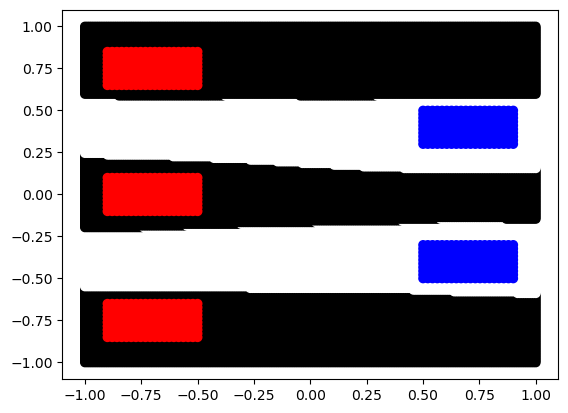

In [14]:
def x2_direction(inp):
    batch_size = tf.shape(inp)[0]
    result = tf.zeros((batch_size, 2), dtype=tf.float32)
    for i in range(batch_size):
        x = inp[i, 1]
        if (x<0.85 and 0.65<x) or ( x < 0.1 and -0.1 < x) or (x<-0.65 and -0.85<x):
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [10.0, 0.1])
        elif (x<0.55 and 0.35<x) or (x < -0.3 and -0.5 < x):
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [0.1, 10.0])
        else:
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [0.1, 0.1])


    return result
    
result = prior_exp(x2_direction)

# Without VPM

In [15]:
coeff = 0.3
activation = 'relu'



def prior_exp(beta_func,coeff = coeff):
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Dense(50, activation=activation, use_bias=True, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    # model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = BMF_loss(coeff = coeff, beta_func = beta_func))
    # model.compile(optimizer = tf.keras.optimizers.Adam(), loss ='CategoricalCrossEntropy')

    model.fit(X,np.append(tf.expand_dims(Y, axis = -1),X[:,:],axis = 1),epochs = 200, verbose = 0)
    result,xx,yy = draw_prediction(model, xlim = [-1,1], ylim = [-1,1], num = [200,200])
    # prediction = ((result[:,0]<0.9) & (0.1<result[:,0]))
    prediction = np.argmax(result, axis = -1)
   
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(xx,yy, c=prediction, label='decision boundary',cmap= newcmp)
    ax1.scatter(X[:,0],X[:,1], c=Y, label='data',cmap = blockcmp)
#     plt.legend(loc='upper left')
#     plt.scatter(xx,yy, c=prediction)
#     plt.scatter(X[:,0],X[:,1], c=Y)
#     ax = sns.heatmap(tf.reshape(prediction,[200,200]))
    plt.show()
    return result

In [16]:
class BMF_loss(tf.keras.losses.Loss):
    def __init__(self, coeff, beta_func = 0):
        super().__init__()
        self.coeff = coeff
        self.beta_func = beta_func
    def call(self, y_true, y_pred):
        inp = y_true[:,1:]
        y_true = y_true[:,0]
        alphas = tf.math.exp(y_pred) + 1e-9
#         tf.print(alphas)
#         tf.print(tf.shape(alphas))
#         betas = tf.ones_like(y_pred) * 5 * inp**2
#         betas = tf.ones_like(y_pred) * self.beta_func(tf.stop_gradient(inp))
        betas = tf.ones_like(y_pred) * self.beta_func(inp)
#         tf.print(tf.shape(alphas))
#         tf.print(y_true)
        a_ans = tf.gather(alphas,axis=-1, indices = tf.cast(y_true,'int32'), batch_dims = 1)
#         a_ans = alphas[:,y_true[-1]]
#         tf.print(tf.shape(y_true))
#         tf.print((tf.shape(a_ans)))
#         tf.print((tf.expand_dims(a_ans,-1)-alphas))
        a_zero = tf.math.reduce_sum(alphas,-1)
        beta_zero = tf.math.reduce_sum(betas,-1)
#         tf.print(tf.shape(a_zero))
        
        l1_loss = tf.math.digamma(a_ans) - tf.math.digamma(a_zero)
#         l1_loss = tf.math.log(a_ans) - tf.math.log(a_zero)
#         tf.print((l1_loss))

        loss1 = tf.math.lgamma(a_zero) - tf.math.reduce_sum(tf.math.lgamma(alphas), -1)
        loss1 += -tf.math.lgamma(beta_zero) + tf.math.reduce_sum(tf.math.lgamma(betas), -1)
        loss2 = tf.math.reduce_sum((alphas - betas)*(tf.math.digamma(alphas) - tf.math.digamma(tf.expand_dims(a_zero,-1))),-1)

#         print(tf.shape(loss1))
#         print(tf.shape(loss2))
        kl_loss = loss1 + loss2
#         print((kl_loss))

        loss = tf.math.reduce_mean(self.coeff*kl_loss - l1_loss)
#         print((loss))
        return loss

In [18]:
X,Y = generate_data(
    xlim = [-1,1],
    ylim = [-1,1], 
    n_point_per_axis = [20,10], 
    lenth_per_slab = 0.4, 
    width_per_slab = 0.2, 
    gap_to_edge_1 = [0.1,0.15],
    gap_to_edge_2 = [0.1, 0.5],
    n_slab1 = 3, 
    n_slab2 = 2,
)
Y = tf.cast(Y,'int32')

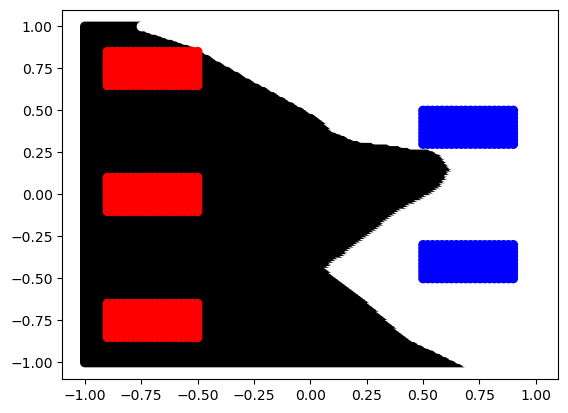

<tf.Tensor: shape=(40000, 2), dtype=float32, numpy=
array([[  4.3932014,  -3.9207113],
       [  4.4068456,  -3.908258 ],
       [  4.4204874,  -3.8958054],
       ...,
       [-75.23697  ,  17.617271 ],
       [-75.50673  ,  17.677597 ],
       [-75.77645  ,  17.737923 ]], dtype=float32)>

In [19]:

def x2_direction(inp):
    batch_size = tf.shape(inp)[0]
    result = tf.zeros((batch_size, 2), dtype=tf.float32)
    for i in range(batch_size):
        x = inp[i, 1]
        if (x<0.85 and 0.65<x) or ( x < 0.1 and -0.1 < x) or (x<-0.65 and -0.85<x):
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [10, 0.0])
        elif (x<0.55 and 0.35<x) or (x < -0.3 and -0.5 < x):
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [0.0, 10])
        else:
            result = tf.tensor_scatter_nd_update(result, [[i, 0], [i, 1]], [0.1, 0.1])


    return result
    
prior_exp(x2_direction)